In [1]:
import itertools
import json
import operator
import os
from pathlib import Path
from pprint import pprint
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

## Load data and preprocess

### Metadata

In [2]:
# Map from test suite tag to high-level circuit.
circuits = {
    "Licensing": ["npi", "reflexive"],
    "Long-Distance Dependencies": ["fgd", "embed", "number", "comparison"],
    "Garden-Path Effects": ["gardenpath", "npz", "mvrr"],
    "Gross Syntactic State": ["subordination", "nn"],
    "Center Embedding": ["center"],
    "Transformations": ["cleft"],
}

tag_to_circuit = {tag: circuit
                  for circuit, tags in circuits.items()
                  for tag in tags}

In [3]:
# Exclusions
exclude_suite_re = re.compile(r"^fgd-embed[34]|^npz_(ambig)|^gardenpath")

### Load

In [4]:
os.chdir("..")
ppl_data_path = Path("data/raw/perplexity.csv")
test_suite_results_path = Path("data/raw/test_suite_results")

In [6]:
perplexity_df = pd.read_csv(ppl_data_path, index_col=["model", "corpus", "seed"])
perplexity_df.index.set_names("model_name", level=0, inplace=True)

results_df = pd.concat([pd.read_csv(f) for f in test_suite_results_path.glob("*.csv")])

# Split model_id into constituent parts
model_ids = results_df.model.str.split("_", expand=True).rename(columns={0: "model_name", 1: "corpus", 2: "seed"})
results_df = pd.concat([results_df, model_ids], axis=1).drop(columns=["model"])
results_df["seed"] = results_df.seed.fillna("0").astype(int)

# Exclude test suites
exclude_filter = results_df.suite.str.contains(exclude_suite_re)
print("Dropping %i results / %i suites due to exclusions."
      % (exclude_filter.sum(), len(results_df[exclude_filter].suite.unique())))
results_df = results_df[~exclude_filter]

# Add tags
results_df["tag"] = results_df.suite.transform(lambda s: re.split(r"[-_0-9]", s)[0])
results_df["circuit"] = results_df.tag.map(tag_to_circuit)
tags_missing_circuit = set(results_df.tag.unique()) - set(tag_to_circuit.keys())
if tags_missing_circuit:
    print("Tags missing circuit: ", ", ".join(tags_missing_circuit))

Dropping 2564 results / 6 suites due to exclusions.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if sys.path[0] == '':


In [7]:
results_df.head()

,suite,item,correct,model_name,corpus,seed,tag,circuit
0,fgd_subject,0,True,ngram,bllip-lg,0,fgd,Long-Distance Dependencies
1,fgd_subject,1,False,ngram,bllip-lg,0,fgd,Long-Distance Dependencies
2,fgd_subject,2,True,ngram,bllip-lg,0,fgd,Long-Distance Dependencies
3,fgd_subject,3,True,ngram,bllip-lg,0,fgd,Long-Distance Dependencies
4,fgd_subject,4,True,ngram,bllip-lg,0,fgd,Long-Distance Dependencies


### Checks

In [8]:
# Each model--corpus--seed should have perplexity data.
ids_from_results = results_df.set_index(["model_name", "corpus", "seed"]).sort_index().index
ids_from_ppl = perplexity_df.sort_index().index
diff = set(ids_from_results) - set(ids_from_ppl)
if diff:
    print("Missing perplexity results for:")
    pprint(diff)
    #raise ValueError("Each model--corpus--seed must have perplexity data.")

Missing perplexity results for:
{('ngram-no-rand', 'bllip-', 0),
 ('ngram-no-rand', 'bllip-xs', 0),
 ('transformer-xl', '', 0)}


In [9]:
# Every model--corpus--seed should have results for all test suite items.
item_list = {model_key: set(results.suite)
             for model_key, results in results_df.groupby(["model_name", "corpus", "seed"])}
not_shared = set()
for k1, k2 in itertools.combinations(item_list.keys(), 2):
    l1, l2 = item_list[k1], item_list[k2]
    if l1 != l2:
        print("SyntaxGym test suite results for %s and %s don't match" % (k1, k2))
        print("\tIn %s but not in %s:\n\t\t%s" % (k2, k1, l2 - l1))
        print("\tIn %s but not in %s:\n\t\t%s" % (k1, k2, l1 - l2))
        print()
        
        not_shared |= l2 - l1
        not_shared |= l1 - l2
        
print(not_shared)

if len(not_shared) > 0:
    to_drop = results_df[results_df.suite.isin(not_shared)]
    print("Dropping these test suites (%i rows) for now. Yikes." % len(to_drop))
    results_df = results_df[~results_df.suite.isin(not_shared)]

set()


## Main analyses

1. barplot ranking model accuracies
2. scatter plot with ppl on x-axis and SG score on y-axis (for a given dataset size -- or maybe all of them together?)
3. variance in ppl vs variance in SG score for a single model across seeds and/or sizes

Test suite analyses

1. within-tag/circuit ppl-SG correlations
2. circuit-circuit coordination heatmap
3. robustness to stability modification}

### Global settings

e.g. to maintain consistent hues across model graphs, etc.

In [10]:
model_order = sorted(set(results_df.model_name))
corpus_order = ["bllip-lg", "bllip-md", "bllip-sm", "bllip-xs"]
circuit_order = sorted([c for c in results_df.circuit.dropna().unique()])

### Data prep

In [11]:
suites_df = results_df.groupby(["model_name", "corpus", "seed", "suite"]).correct.mean().reset_index()
suites_df["tag"] = suites_df.suite.transform(lambda s: re.split(r"[-_0-9]", s)[0])
suites_df["circuit"] = suites_df.tag.map(tag_to_circuit)

In [12]:
# Join PPL and accuracy data.
joined_data = suites_df.groupby(["model_name", "corpus", "seed"]).correct.agg("mean")
joined_data = pd.DataFrame(joined_data).join(perplexity_df).reset_index()
joined_data.head()

,model_name,corpus,seed,correct,pid,test_loss,test_ppl
0,ngram,bllip-lg,0,0.378650,NaN,NaN,106.0919
1,ngram,bllip-md,0,0.375331,NaN,NaN,125.5826
2,ngram,bllip-sm,0,0.330714,NaN,NaN,158.5957
3,ngram,bllip-xs,0,0.385804,NaN,NaN,240.2087
4,ngram-no-rand,bllip-,0,0.103977,NaN,NaN,NaN


In [13]:
# Join PPL and accuracy data, splitting on circuit.
joined_data_circuits = suites_df.groupby(["model_name", "corpus", "seed", "circuit"]).correct.agg("mean")
joined_data_circuits = pd.DataFrame(joined_data_circuits).reset_index().set_index(["model_name", "corpus", "seed"]).join(perplexity_df).reset_index()
joined_data_circuits.head()

,model_name,corpus,seed,circuit,correct,pid,test_loss,test_ppl
0,ngram,bllip-lg,0,Center Embedding,0.500000,NaN,NaN,106.0919
1,ngram,bllip-lg,0,Garden-Path Effects,0.412202,NaN,NaN,106.0919
2,ngram,bllip-lg,0,Gross Syntactic State,0.426087,NaN,NaN,106.0919
3,ngram,bllip-lg,0,Licensing,0.236842,NaN,NaN,106.0919
4,ngram,bllip-lg,0,Long-Distance Dependencies,0.390977,NaN,NaN,106.0919


In [14]:
# Analyze stability to modification.
def has_modifier(ts):
    if ts.endswith(("_modifier", "_mod")):
        return True
    else:
        return None
results_df["has_modifier"] = results_df.suite.transform(has_modifier)

# Mark "non-modifier" test suites
modifier_ts = results_df[results_df.has_modifier == True].suite.unique()
no_modifier_ts = [re.sub(r"_mod(ifier)?$", "", ts) for ts in modifier_ts]
results_df.loc[results_df.suite.isin(no_modifier_ts), "has_modifier"] = False
# Store subset of test suites which have definite modifier/no-modifier marking
results_df_mod = results_df[~(results_df.has_modifier.isna())].copy()
# Get base test suite (without modifier/no-modifier marking)
results_df_mod["test_suite_base"] = results_df_mod.suite.transform(lambda ts: ts.strip("_no-modifier").strip("_modifier"))
results_df_mod.head()

,suite,item,correct,model_name,corpus,seed,tag,circuit,has_modifier,test_suite_base
24,npz_obj_mod,0,False,ngram,bllip-lg,0,npz,Garden-Path Effects,True,pz_obj
25,npz_obj_mod,1,False,ngram,bllip-lg,0,npz,Garden-Path Effects,True,pz_obj
26,npz_obj_mod,2,True,ngram,bllip-lg,0,npz,Garden-Path Effects,True,pz_obj
27,npz_obj_mod,3,True,ngram,bllip-lg,0,npz,Garden-Path Effects,True,pz_obj
28,npz_obj_mod,4,False,ngram,bllip-lg,0,npz,Garden-Path Effects,True,pz_obj


### `ngram` sanity checks

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'ngram test suite results, averaged across corpus size')

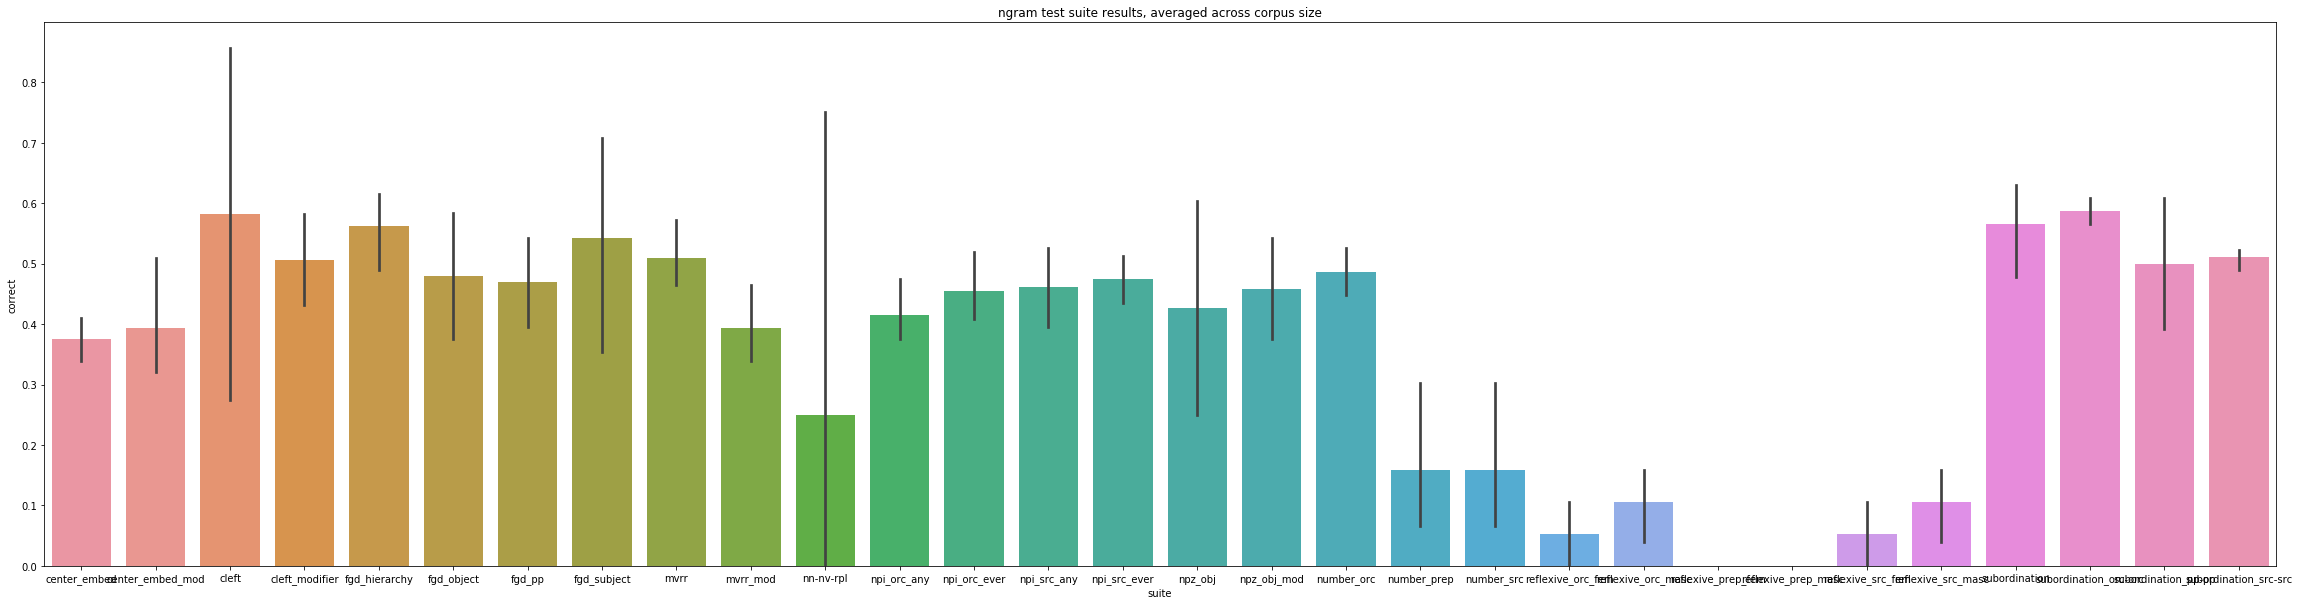

In [15]:
plt.subplots(figsize=(40, 10))
sns.barplot(data=suites_df[suites_df.model_name == "ngram"], x="suite", y="correct")
plt.title("ngram test suite results, averaged across corpus size")

Text(0.5,1,'ngram-no-rand test suite results, averaged across corpus size')

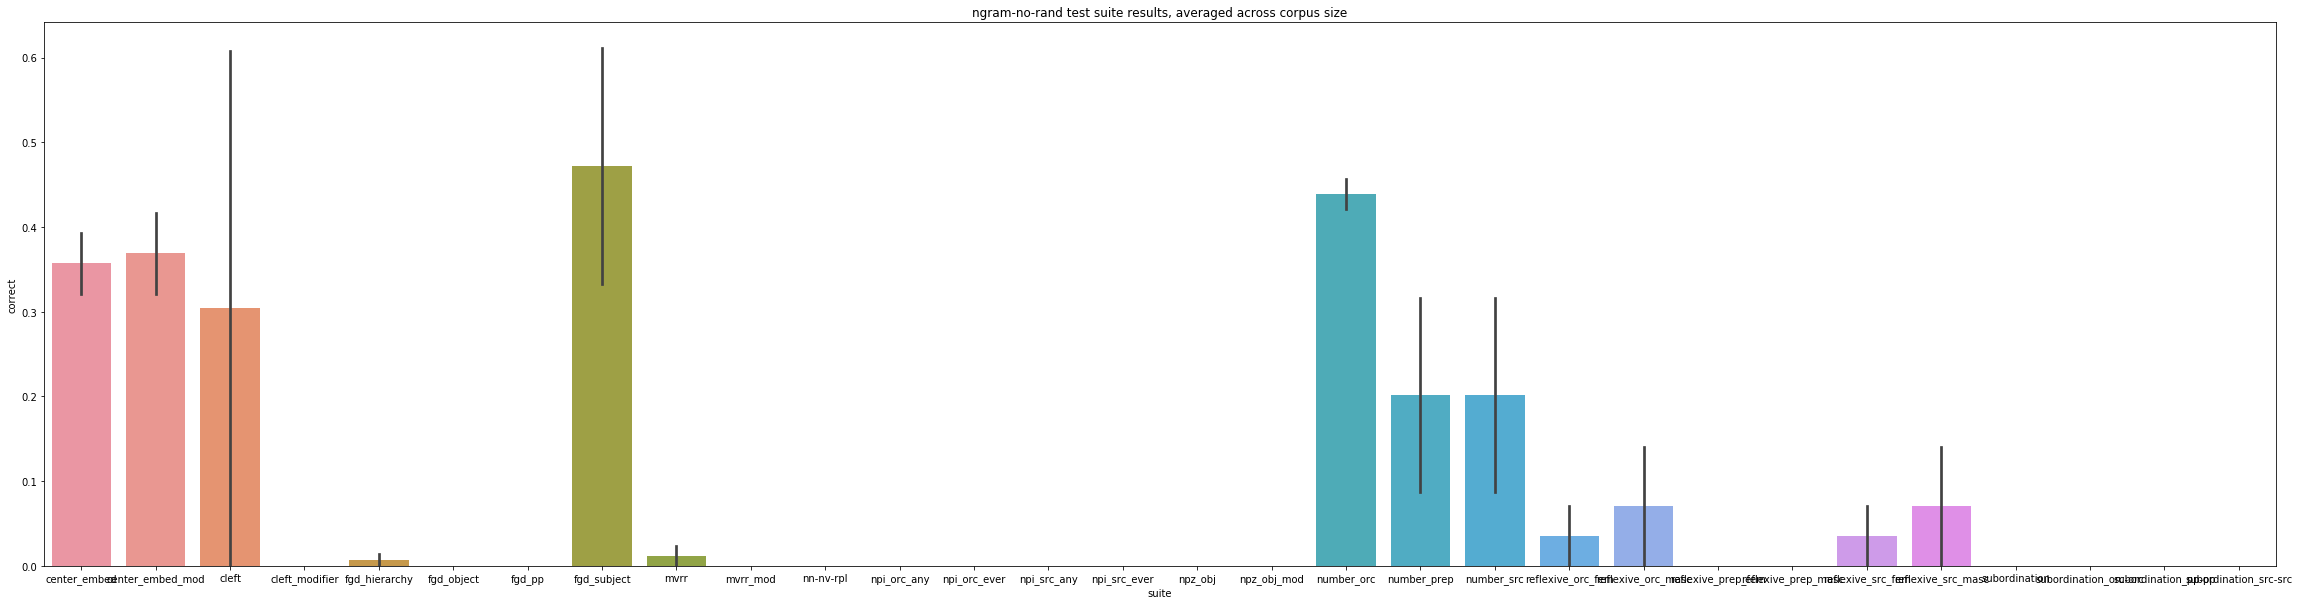

In [24]:
plt.subplots(figsize=(40, 10))
sns.barplot(data=suites_df[suites_df.model_name == "ngram-no-rand"], x="suite", y="correct")
plt.title("ngram-no-rand test suite results, averaged across corpus size")

### Accuracy across models

Text(0,0.5,'Accuracy')

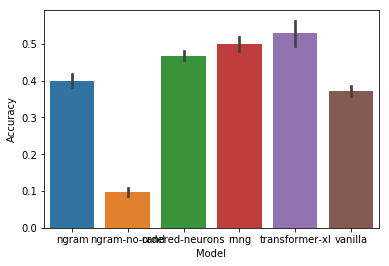

In [16]:
sns.barplot(data=results_df.reset_index(), x="model_name", y="correct")

plt.xlabel("Model")
plt.ylabel("Accuracy")

### Accuracy vs perplexity

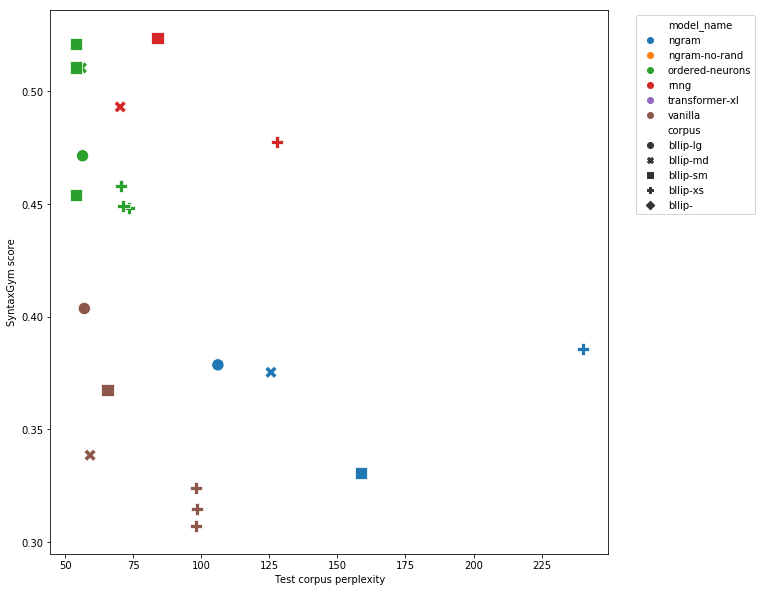

In [17]:
f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=joined_data, x="test_ppl", y="correct",
                hue="model_name", style="corpus", s=150,
                hue_order=model_order)
plt.xlabel("Test corpus perplexity")
plt.ylabel("SyntaxGym score")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

(0, 1)

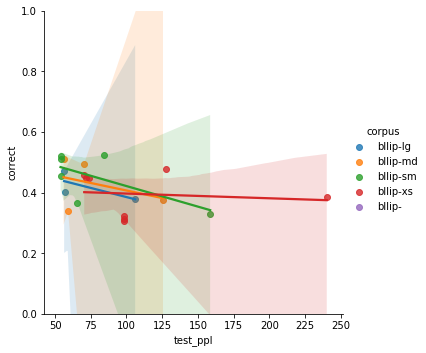

In [18]:
g = sns.lmplot(data=joined_data, x="test_ppl", y="correct",
               hue="corpus", truncate=True)
g.ax.set_ylim((0, 1))

(0, 1)

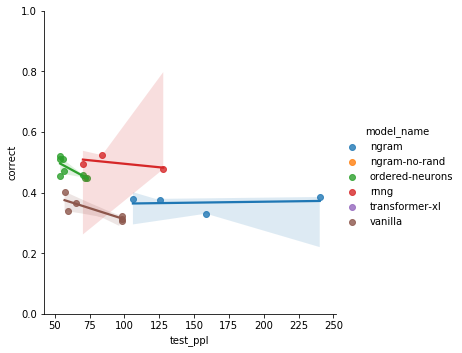

In [19]:
g = sns.lmplot(data=joined_data, x="test_ppl", y="correct",
               hue="model_name", truncate=True)
g.ax.set_ylim((0, 1))

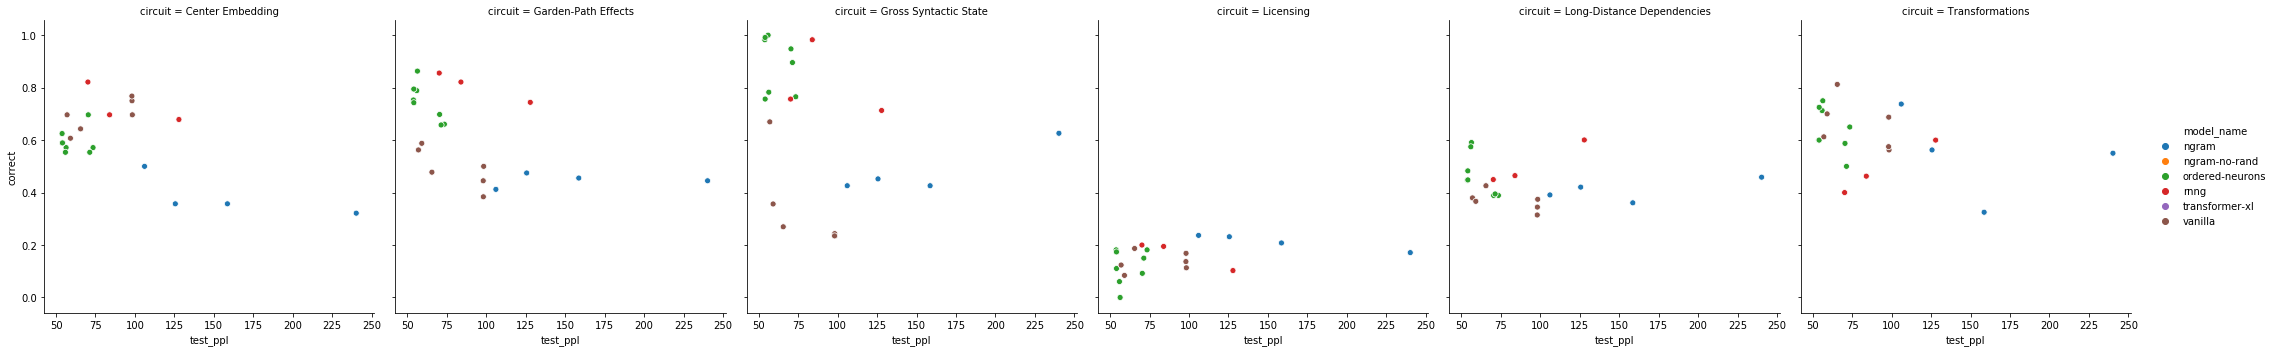

In [20]:
g = sns.FacetGrid(data=joined_data_circuits, col="circuit", height=5)
g.map(sns.scatterplot, "test_ppl", "correct", "model_name",
      hue_order=model_order)
g.add_legend()

In [21]:
joined_data_circuits.groupby(["model_name", "corpus", "circuit"]).correct.mean()

model_name      corpus    circuit                   
ngram           bllip-lg  Center Embedding              0.500000
                          Garden-Path Effects           0.412202
                          Gross Syntactic State         0.426087
                          Licensing                     0.236842
                          Long-Distance Dependencies    0.390977
                          Transformations               0.737500
                bllip-md  Center Embedding              0.357143
                          Garden-Path Effects           0.474702
                          Gross Syntactic State         0.452174
                          Licensing                     0.231579
                          Long-Distance Dependencies    0.420739
                          Transformations               0.562500
                bllip-sm  Center Embedding              0.357143
                          Garden-Path Effects           0.455357
                          Gross Synta

### Item-level prediction correlations across models

In [22]:
item_predictions = results_df.set_index(["suite", "item"]).sort_index().groupby(["model_name", "corpus", "seed"]).correct.apply(np.array)
model_correlations = []
for k1, k2 in itertools.combinations(list(item_predictions.index), 2):
    model_correlations.append(("_".join(map(str, k1)), *k1, "_".join(map(str, k2)), *k2, stats.spearmanr(item_predictions.loc[k1], item_predictions.loc[k2])[0]))

corr_df = pd.DataFrame(model_correlations, columns=["key_1", "model_1", "corpus_1", "seed_1", "key_2", "model_2", "corpus_2", "seed_2", "corr"])

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [ ]:
plt.subplots(figsize=(10, 10))
sns.heatmap(data=corr_df.pivot("key_1", "key_2", "corr"))

In [ ]:
plt.subplots(figsize=(10, 10))
sns.distplot(results_df.groupby(["suite", "item"]).correct.agg("mean"), bins=20)
plt.title("Distribution of item-level accuracy means")

In [ ]:
plt.subplots(figsize=(10, 10))
sns.distplot(results_df.groupby(["suite", "item"]).correct.agg("std"), bins=20)
plt.title("Distribution of item-level accuracy stdevs")

In [ ]:
plt.subplots(figsize=(10, 10))
sns.distplot(suites_df.correct, bins=20)
plt.title("Distribution of suite-level accuracy means")

### Variance in accuracy vs variance in perplexity

In [ ]:
catplot_ticks = ["correct", "test_ppl"]
catplot_data = joined_data.copy()
catplot_data["correct"] *= 100
catplot_data = catplot_data.melt(id_vars=set(catplot_data.columns) - set(catplot_ticks))
# catplot_data["corpus_size"] = catplot_data.corpus.map(corpus_to_size)

g = sns.catplot(data=catplot_data,
                x="variable", y="value", hue="model_name")

### Circuit–circuit correlations

In [ ]:
f, axs = plt.subplots(len(circuit_order), len(circuit_order), figsize=(20, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for c1, row in zip(circuit_order, axs):
    for c2, ax in zip(circuit_order, row):
        if c1 <= c2:
            ax.axis("off")
            continue
            
        xs = results_df[results_df.circuit == c1].groupby(["model_name", "corpus", "seed"]).correct.agg({c1: "mean"})
        ys = results_df[results_df.circuit == c2].groupby(["model_name", "corpus", "seed"]).correct.agg({c2: "mean"})
        df = pd.concat([xs, ys], axis=1)
        ax.set_title("%s /\n %s" % (c1, c2))
        sns.regplot(data=df, x=c1, y=c2, ax=ax)
        
plt.suptitle("Circuit--circuit correlations")

### Stability to modification

In [ ]:
plt.subplots(figsize=(15, 10))
sns.barplot(data=results_df_mod, x="model_name", y="correct", hue="has_modifier")
plt.title("Stability to modification")

In [ ]:
plt.subplots(figsize=(15, 10))
sns.barplot(data=results_df_mod, x="corpus", y="correct", hue="has_modifier")
plt.title("Stability to modification")

In [ ]:
g = sns.FacetGrid(data=results_df_mod, col="model_name", height=7)
g.map(sns.barplot, "corpus", "correct", "has_modifier")

In [ ]:
avg_mod_results = results_df_mod.groupby(["model_name", "test_suite_base", "has_modifier"]).correct.agg({"correct": "mean"}).sort_index()
avg_mod_diffs = avg_mod_results.xs(True, level="has_modifier") - avg_mod_results.xs(False, level="has_modifier")

plt.subplots(figsize=(15, 10))
sns.boxplot(data=avg_mod_diffs.reset_index(), x="model_name", y="correct")
plt.title("Change in accuracy due to modification")